In [2]:
#Dataset diambil di kaggle/rockpaperscissors

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
 
os.listdir('drive/My Drive/SOURCE DATA SCIENCE/rps-cv-images')

['rock', 'scissors', 'paper']

In [ ]:
rock = os.listdir('drive/My Drive/SOURCE DATA SCIENCE/rps-cv-images/rock')

df_rock = pd.DataFrame(rock, columns=['image_id'])

df_rock.head()

,image_id
0,aM5kGWsMPDGNdc3J.png
1,MhOAtto6kcc8xsKr.png
2,aWvWsXj1NL19dskm.png
3,c1rdxANL8E7yG3ZI.png
4,TgCDIOp6r8sKduvT.png


In [ ]:
df_rock.shape

(726, 1)

In [ ]:
scissors = os.listdir('drive/My Drive/SOURCE DATA SCIENCE/rps-cv-images/scissors')

df_scissors = pd.DataFrame(scissors, columns=['image_id'])

df_scissors.head()

,image_id
0,M8ctr4cjddfGnoWg.png
1,FEpMZLoRy5eAgRvh.png
2,LNyVq7Qg9M0S6RMZ.png
3,PQTyLq9Esb7RzmzH.png
4,JTzFGcfB5wsRyDrm.png


In [ ]:
df_scissors.shape

(750, 1)

In [ ]:
paper = os.listdir('drive/My Drive/SOURCE DATA SCIENCE/rps-cv-images/paper')

df_paper = pd.DataFrame(paper, columns=['image_id'])

df_paper.head()

,image_id
0,JQaNQ7LsPy3cY23Q.png
1,9qKKOliWXD7oDZOd.png
2,BTG0fjXM09DyD4sh.png
3,Qxx5l8WCNBjMb5xI.png
4,BLqL31aC5YLmx3uF.png


In [ ]:
df_paper.shape

(712, 1)

In [ ]:
subpath= 'drive/My Drive/SOURCE DATA SCIENCE/rps-cv-images/'

In [ ]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(subpath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [ ]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
paper       712
rock        726
scissors    750
dtype: int64

In [ ]:
#cek sample datanya
df.head()

,path,file_name,tag
0,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,aM5kGWsMPDGNdc3J.png,rock
1,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,MhOAtto6kcc8xsKr.png,rock
2,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,aWvWsXj1NL19dskm.png,rock
3,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,c1rdxANL8E7yG3ZI.png,rock
4,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,TgCDIOp6r8sKduvT.png,rock


**TRAIN TEST SPLIT-PREPARATION**

In [ ]:
#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

In [ ]:
# split dataset menjadi data train dan test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=101)

In [ ]:

# satukan kedalam masing-masing df

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [ ]:
print('train size', len(df_tr))
print('val size', len(df_val))

train size 1312
val size 876


In [ ]:
# cek masing-masing set dalam direktori
df_all = df_tr.append([df_val]).reset_index(drop=1)\

print('================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('================================================== \n')

#cek sample datanya
df_all.sample(3)


set         tag     
train       paper       439
            rock        441
            scissors    432
validation  paper       273
            rock        285
            scissors    318
dtype: int64 




,path,tag,set
1846,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,rock,validation
1725,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,paper,validation
1346,drive/My Drive/SOURCE DATA SCIENCE/rps-cv-imag...,rock,validation


In [ ]:
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
datasource_path = "drive/My Drive/SOURCE DATA SCIENCE/rps-cv-images/"
dataset_path = "drive/My Drive/SOURCE DATA SCIENCE/split_data_rsp/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make direktori destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file destinasi
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file dari sourse ke dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

**END PREPARATION --> MODELLING**

In [ ]:
image_size = 50
image_channels = 3

In [ ]:
train_path = 'drive/My Drive/SOURCE DATA SCIENCE/split_data_rsp/train'
val_path = 'drive/My Drive/SOURCE DATA SCIENCE/split_data_rsp/validation'

train_steps = 50
val_steps = 50

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             shear_range = 0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(image_size,image_size),
                                        batch_size=16,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(val_path,
                                        target_size=(image_size,image_size),
                                        batch_size=16,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(val_path,
                                        target_size=(image_size,image_size),
                                        batch_size=16,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(50,50,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#filepath = "modelrsp3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
                              
                              
callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=60, verbose=1,
                   callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
50/50 [==============================] - 1190s 24s/step - loss: 0.6396 - accuracy: 0.3187 - val_loss: 0.6342 - val_accuracy: 0.3700
Epoch 2/60
50/50 [==============================] - 263s 5s/step - loss: 0.6349 - accuracy: 0.3475 - val_loss: 0.6323 - val_accuracy: 0.4187
Epoch 3/60
50/50 [==============================] - 93s 2s/step - loss: 0.6271 - accuracy: 0.4350 - val_loss: 0.6202 - val_accuracy: 0.4500
Epoch 4/60
50/50 [==============================] - 39s 774ms/step - loss: 0.6057 - accuracy: 0.4712 - val_loss: 0.5987 - val_accuracy: 0.4437
Epoch 5/60
50/50 [==============================] - 26s 525ms/step - loss: 0.6124 - accuracy: 0.4387 - val_loss: 0.5964 - val_accuracy: 0.5325
Epoch 6/60
50/50 [==============================] - 9s 186ms/step - loss: 0.5751 - accuracy: 0.5813 - val_loss: 0.5538 - val_accuracy: 0.5925
Epoch 7/60
50/50 [==============================] - 8s 154ms/step - loss

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
train_loss, train_acc = \
model.evaluate_generator(train_gen, steps=len(df_val))

print('val_loss:', train_loss)
print('val_acc:', train_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
val_loss: 0.05697309598326683
val_acc: 0.9710366129875183


In [ ]:
val_loss, val_acc = \
model.evaluate_generator(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.052089180797338486
val_acc: 0.9771689772605896


In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

 55/876 [>.............................] - 3s 59ms/step


In [ ]:
predictions.shape

(876, 3)

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['paper', 'rock','scissors'])

df_preds.head()

,paper,rock,scissors
0,0.999621,0.000100,0.000279
1,0.986779,0.000552,0.012669
2,0.844298,0.105649,0.050053
3,0.998762,0.000559,0.000679
4,0.945651,0.000076,0.054273


In [ ]:
test_gen.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
# Get the true labels
y_test = test_gen.classes

In [ ]:
from sklearn.metrics import classification_report

# we need y_pred as binary labels not as probabilities
y_pred = predictions.argmax(axis=1)

plot_labels = ['paper', 'rock', 'scissors']

report = classification_report(y_test, y_pred, target_names=plot_labels)

print(report)

              precision    recall  f1-score   support

       paper       0.98      0.96      0.97       273
        rock       0.98      0.97      0.97       285
    scissors       0.96      0.99      0.97       318

    accuracy                           0.97       876
   macro avg       0.97      0.97      0.97       876
weighted avg       0.97      0.97      0.97       876



Text(0.5, 15.0, 'Predicted label')

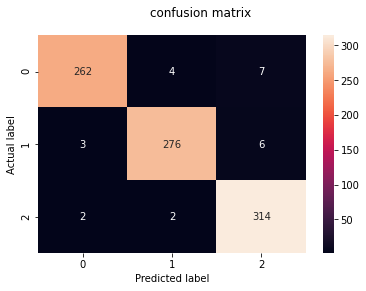

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

fig = plt.figure()
fig.suptitle('confusion matrix')
sn.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


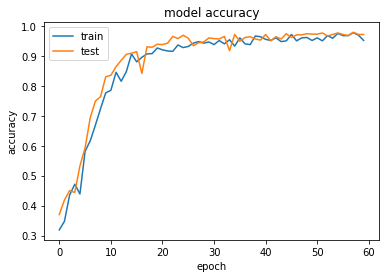

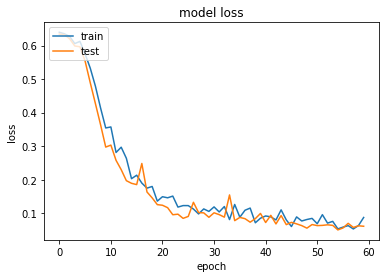

In [ ]:
# list all data in history
print(history.history.keys())
# acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving 0NDYNEoDui7o64gU.png to 0NDYNEoDui7o64gU.png
0NDYNEoDui7o64gU.png
rock


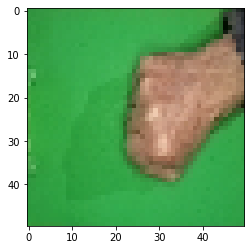

In [ ]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()

for fn in uploaded.keys():
  
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(50,50))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = x/255
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print('=============================================')

  if classes[0][0] == 1:
    print('paper')
  elif classes[0][1] == 1:
    print('rock')
  elif classes[0][2] == 1:
    print('scissors')

